<a target="_blank" href="https://colab.research.google.com/github/ChrisD-7/MI564/blob/main/w2vec.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The Simpsons reference in class didn't quite resonate, so I thought a Harry Potter approach might be more relatable! (No worries if you haven't read the books – we'll focus on the magic of language, not spells.)

## We'll build on the same methods used in our previous Word2Vec intro file.

In [27]:
#regular imports 
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

#gensim imports
import re
import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim import corpora
from collections import defaultdict



# ntlk imports 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer

In [28]:
#setting down our plotting parameters for our dirgrams just like our main code

plt.rcParams.update({'font.size':20,'figure.figsize':(10,8)})

In [29]:
#http://www.nltk.org/_modules/nltk/tokenize/punkt.html
nltk.download('punkt')
#Wordnet is important for Lemmatization ==> seel later when we dig into this
#https://www.nltk.org/howto/wordnet.html
nltk.download('wordnet')
#use nltk to get stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
#create a stoplist that includes all the english stop words
stopwords_english = stopwords.words('english')
display('here is a subset of the stop words')
display(stopwords_english[0:10])

# Text Cleaning
import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim')

'here is a subset of the stop words'

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

To keep things relevent i have selected a harry potter dataset that can be found [here](https://www.kaggle.com/datasets/eward96/harry-potter-and-the-chamber-of-secrets-script)

In [34]:
#nltk lemmatizer 
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [35]:
df = pd.read_excel("HarryPotter_2.xlsx")

In [36]:
df.head()

,ID_number,scene,character_name,dialogue
0,1,1,Harry Potter,"I can't let you out, Hedwig. I'm not allowed t..."
1,2,1,Vernon Dursley,Harry Potter!!
2,3,1,Harry Potter,Now you've done it.
3,4,1,Petunia Dursley,"He's in there, Vernon."
4,5,1,Vernon Dursley,I'm warning you. If you can't control that blo...


In [37]:
df.drop(columns=['ID_number', 'scene'])

,character_name,dialogue
0,Harry Potter,"I can't let you out, Hedwig. I'm not allowed t..."
1,Vernon Dursley,Harry Potter!!
2,Harry Potter,Now you've done it.
3,Petunia Dursley,"He's in there, Vernon."
4,Vernon Dursley,I'm warning you. If you can't control that blo...
...,...,...
915,Albus Dumbledore,"Before we begin the feast, let us have a round..."
916,Hermione Granger,Oh no!
917,Rubeus Hagrid,Sorry I'm late! The owl that delivered my rele...
918,Harry Potter,"Well there's no Hogwarts without you, Hagrid."


In [38]:
#creating the same clean pass function
def clean_pass(text): 
    #make string lowercase 
    text = str(text)
    text = text.lower()

    #tokenize
    #create bag of words
    #1-grams 
    tokens = nltk.word_tokenize(text) 
    clean_text = []
    
    #remove stopwords, puncuation, then lemmatize
    for word in tokens:
        if (word not in stopwords_english and word not in string.punctuation): 
            token = wordnet_lemmatizer.lemmatize(word)
            clean_text.append(token)
            
    #remove words of length 3 or smaller        
    clean_text = [token for token in clean_text if len(token) > 2] 
            
    return clean_text   

In [39]:
df['clean_text'] = df.dialogue.apply(clean_pass)

df.clean_text

0      [n't, let, hedwig, allowed, use, magic, outsid...
1                                        [harry, potter]
2                                            ['ve, done]
3                                               [vernon]
4             [warning, n't, control, bloody, bird, 'll]
                             ...                        
915    [begin, feast, let, round, applause, professor...
916                                                   []
917    [sorry, late, owl, delivered, release, paper, ...
918                    [well, hogwarts, without, hagrid]
919                                                   []
Name: clean_text, Length: 920, dtype: object

# Model Creation

Now for the next part i did want to update the parameters but since we are focusing on recreating it lets just do that for now.

#UPDATE :
I noticed that when i tried to add a size to it it returned a error thats because the size parameter has been changed

[Updated Parameters](https://radimrehurek.com/gensim/models/word2vec.html#usage-examples:~:text=model%20%3D%20Word2Vec(sentences%3Dcommon_texts%2C%20vector_size%3D100%2C%20window%3D5%2C%20min_count%3D1%2C%20workers%3D4)%0A%3E%3E%3E%20model.save(%22word2vec.model%22))

In [67]:
'''
Parameters:
**********
**********

min_count: tells word2vec to ignore rare words. These are words with lower frequency compared to the specified value.

size: This is the size of the hidden layer which, in turn, determines the size of the word 
embedding vector. Defaults to 100. You might think that more neurons might capture more nuances, 
but beyond a certain point (higher with the amount of training data) there might be too much noise 
coming down from their initial state. And of course training time and resources will grow as size grows.

window: gives the width of the context: how many surrounding words to consider.

workers:Use these many worker threads to train the model (=faster training with multicore machines). The more cores you 
are using, the faster the model will be trained. 
'''

from gensim.models import Word2Vec
model = Word2Vec(df.clean_text.values, min_count=5,vector_size=300,workers=6, window=5)

Now lets use the weights to find most similar words as we did before syntax has been [updated](https://radimrehurek.com/gensim/models/word2vec.html#usage-examples:~:text=vector%20%3D%20model.wv%5B%27computer%27%5D%20%20%23%20get%20numpy%20vector%20of%20a%20word%0A%3E%3E%3E%20sims%20%3D%20model.wv.most_similar(%27computer%27%2C%20topn%3D10)%20%20%23%20get%20other%20similar%20words) as well 

In [68]:
model.wv.most_similar('harry', topn=10)  # get other similar words


[("n't", 0.5315889120101929),
 ('one', 0.5286136269569397),
 ('would', 0.5275453329086304),
 ('got', 0.4808257818222046),
 ('wizard', 0.47716817259788513),
 ('chamber', 0.469422847032547),
 ('time', 0.46374157071113586),
 ('see', 0.4544062316417694),
 ('must', 0.4475681781768799),
 ('heir', 0.4471481442451477)]

In [69]:
model.wv.most_similar('ron', topn=10)


[('would', 0.30987799167633057),
 ('memory', 0.2755681276321411),
 ("'re", 0.27312061190605164),
 ('harry', 0.2723270058631897),
 ("n't", 0.2635512351989746),
 ('always', 0.26118940114974976),
 ('want', 0.2609812319278717),
 ('voldemort', 0.2607077658176422),
 ('wizard', 0.25863736867904663),
 ('book', 0.25175103545188904)]

In [70]:
model.wv.most_similar('hermione', topn=10)

[("n't", 0.48866385221481323),
 ('would', 0.4464378356933594),
 ('hogwarts', 0.44611746072769165),
 ('chamber', 0.43711814284324646),
 ('one', 0.4364953637123108),
 ("'ll", 0.4246479272842407),
 ('must', 0.40770867466926575),
 ('time', 0.39942339062690735),
 ('see', 0.39832380414009094),
 ('want', 0.38416722416877747)]

In [71]:
model.wv.most_similar('spell', topn=10)  # get other similar words

[('lord', 0.3018459975719452),
 ('potter', 0.2875680923461914),
 ('put', 0.2653965950012207),
 ('one', 0.2645878493785858),
 ('student', 0.25683698058128357),
 ('mr.', 0.24606981873512268),
 ('say', 0.24240538477897644),
 ('could', 0.24059444665908813),
 ('harry', 0.23666857182979584),
 ('ask', 0.23512402176856995)]

In [197]:
model.wv.most_similar('dark', topn=10)  # get other similar words
 

[('time', 0.3381136357784271),
 ('think', 0.3114263117313385),
 ('would', 0.29740846157073975),
 ('power', 0.29730087518692017),
 ('lord', 0.2931098937988281),
 ('way', 0.2836138606071472),
 ("n't", 0.28047746419906616),
 ('must', 0.27984845638275146),
 ("'ll", 0.2735867500305176),
 ('harry', 0.2624039053916931)]

## Now lets look into the similarity between characters

I just wanted to get the most similar and i found something off when comparing harry to ron or hermonie we notice that they arent that similar.
It also kind off odd that harry is most similar to voldemort most probably its because the characters have been mentioned together a lot which means the distances must be less.

In [84]:
model.wv.similarity('harry','ron')

0.27232698

In [86]:
model.wv.similarity('harry','dumbledore')

0.2686218

In [82]:
model.wv.similarity('harry','voldemort')

0.43056005

So lets see who doesnt fit in the mix.

In [90]:
model.wv.doesnt_match(['harry','voldemort','dumbledore'])

'voldemort'

This makes sence 

In [89]:
model.wv.doesnt_match(['harry','ron','hermonie'])

'harry'

Analogy

One of the best way we can see how an analogy works:

In [101]:
model.wv.most_similar(positive=["voldemort", "snake"], negative=["dark"], topn=10)

[('harry', 0.3537120819091797),
 ('one', 0.3365427255630493),
 ("n't", 0.330574631690979),
 ("'re", 0.31469255685806274),
 ('always', 0.3127351701259613),
 ('find', 0.31181129813194275),
 ('back', 0.297953724861145),
 ('would', 0.2918007969856262),
 ('mr.', 0.2904850244522095),
 ('hogwarts', 0.2833647131919861)]

In [102]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.manifold import TSNE

Another change here the vocab.keys has been changed to [key_to_index](https://github.com/piskvorky/gensim/wiki/Migrating-from-Gensim-3.x-to-4#4-vocab-dict-became-key_to_index-for-looking-up-a-keys-integer-index-or-get_vecattr-and-set_vecattr-for-other-per-key-attributes)

In [126]:
#Get all the words in the word2vec model
all_vocab = list(model.wv.key_to_index.keys())

In [129]:
data_dict = {word: model.wv[word] for word in all_vocab}


In [132]:
result = pd.DataFrame(data=data_dict).T
result.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
n't,-0.000187,0.004684,0.000923,0.005850,-0.002635,-0.005548,0.006221,0.010474,-0.002434,-0.002643,...,-0.001545,0.005810,0.004196,-0.001855,0.005887,0.006428,0.002143,-0.002151,0.005023,-0.004811
harry,-0.002794,0.005617,-0.000485,0.000810,0.001758,-0.003063,0.003113,0.006416,0.001646,-0.003293,...,0.003047,0.005117,-0.002094,-0.001340,0.005092,0.004211,-0.000427,-0.004128,0.002227,-0.003632
'll,0.002800,0.001019,-0.000816,0.001902,0.000143,-0.001355,0.004355,0.004050,-0.001521,-0.001187,...,-0.001745,0.002524,0.001505,-0.000840,0.005027,0.005457,0.000924,0.001028,0.003179,-0.003232
dobby,-0.001644,-0.000504,-0.002885,0.003776,-0.000535,-0.003386,0.000128,0.004369,-0.001253,-0.001758,...,0.001623,0.000398,-0.002751,0.001032,0.003626,-0.000155,-0.002495,-0.001879,-0.000800,-0.001650
come,-0.000659,-0.000513,0.002970,-0.002345,0.001605,0.000948,0.000634,0.005068,0.003047,-0.002233,...,0.002471,0.001663,0.001988,0.001972,0.001463,-0.000745,0.000047,0.002109,-0.001464,0.002475


In [139]:
vocab = list(model.wv.key_to_index.keys())

X = [model.wv[word] for word in vocab]


There was an error using the same syntax probably something with the new Update.

In [142]:
vocab = list(model.wv.key_to_index.keys())
X = []
for word in vocab:
  X.append(model.wv[word])


In [ ]:
X

Something weird about exporting that makes it too long so deleted the O/P but its an array:

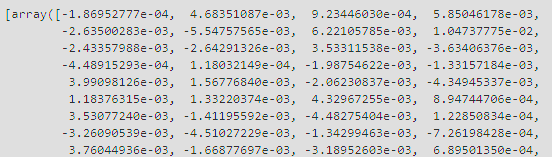

# PCA vs t-SNE

Just for Reference:
Remember when we [introduced PCA](https://github.com/tawfiqam/MI564/blob/main/PCA__Introduction.ipynb) ealier in this class. Principle component analysis is a data reduction and analysis technique that is especially important in "large, mutidimensional datasets." Reducing the dimensionality of the data to principle component analysis can help us better understand the patterns in the data by removing the "noise" from variables that do not contribue much to the understanding of the data structure.

The problem though is that there are too many dimensions in word embeddings (in our case 300 because we set the size to 300). That is why we are going to be using t-SNE instead of PCA.

One of the most major differences between PCA and t-SNE (T- distributed Stochastic Neighbor Embedding) is that t-SNE preserves only local similarities whereas PA preserves large scale variance across the dataset. t-SNE takes a set of points in high dimensional data (as it is in our case) and converts it into low dimensional data.

source:https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d

In [146]:
X_np = np.array(X)
X_tsne = tsne.fit_transform(X_np)


In [148]:
X_tnse_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [149]:
X_tnse_df.head()

,x,y
n't,6.102706,9.511211
harry,5.190547,7.764301
'll,2.885073,8.038263
dobby,1.349891,3.555135
come,-1.487848,-3.950792


In [184]:
def display_closestwords_tsnescatterplot(model, word):
    
    #create an array with the size of the model (300)
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word,topn=20)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv['word']]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coordinates for 2 dimensions
    tsne = TSNE(n_components=2, perplexity=20)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


# Visulizations

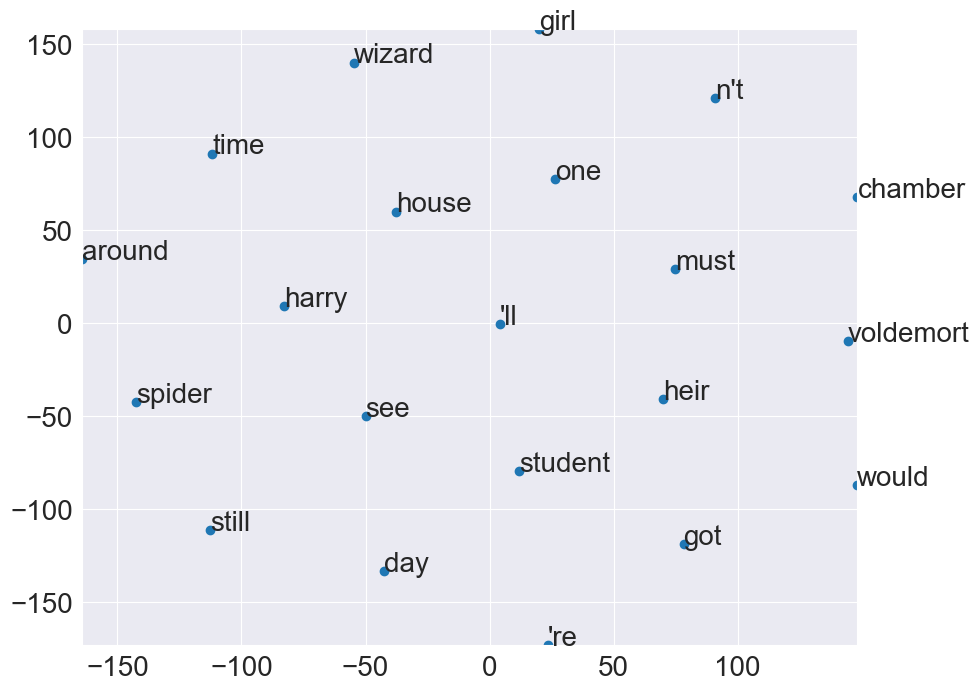

In [185]:
display_closestwords_tsnescatterplot(model,'harry')

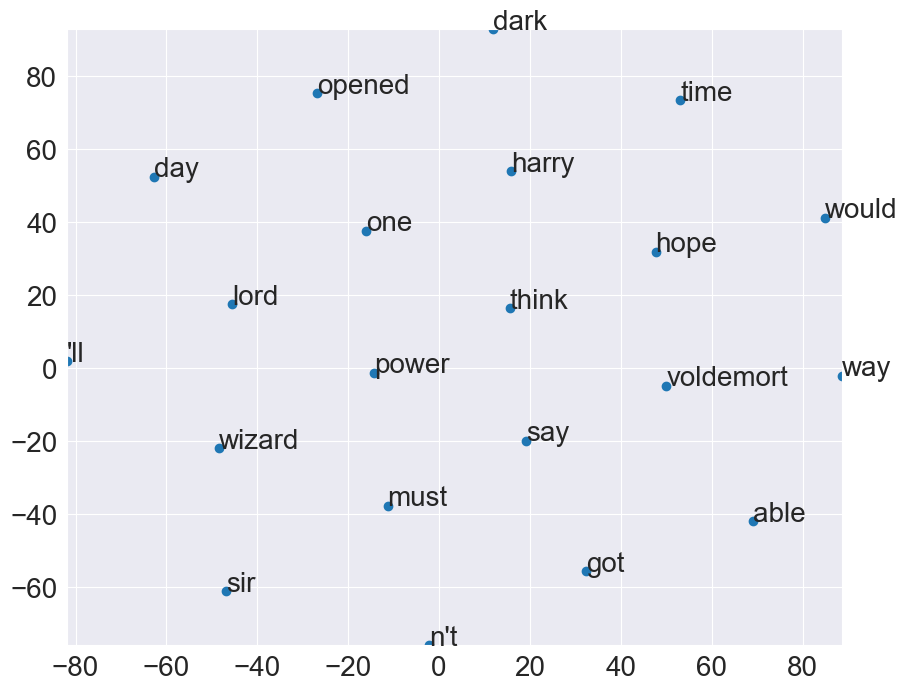

In [186]:
display_closestwords_tsnescatterplot(model,'dark')

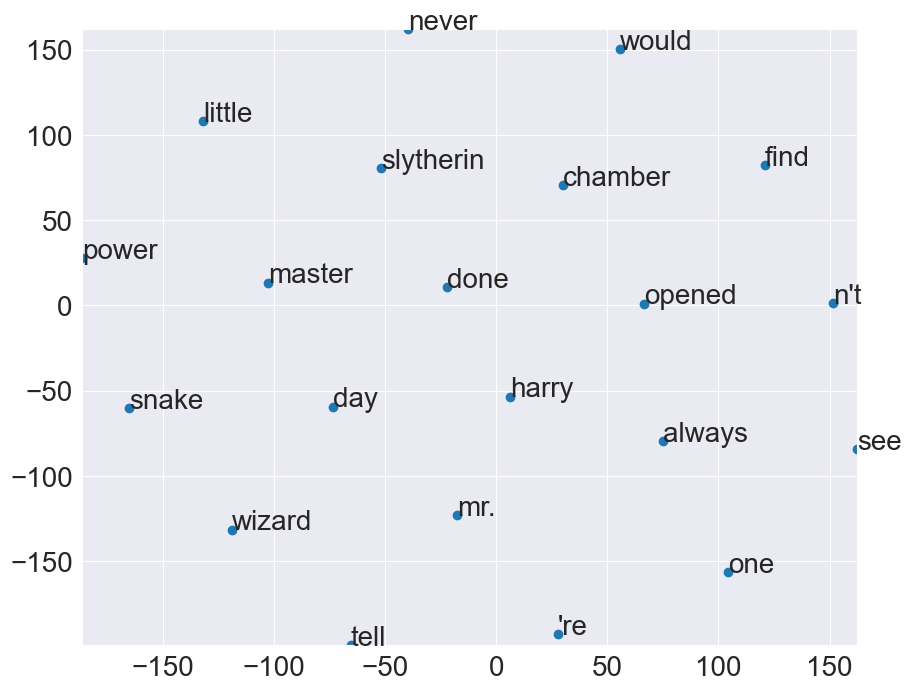

In [187]:
display_closestwords_tsnescatterplot(model,'snake')

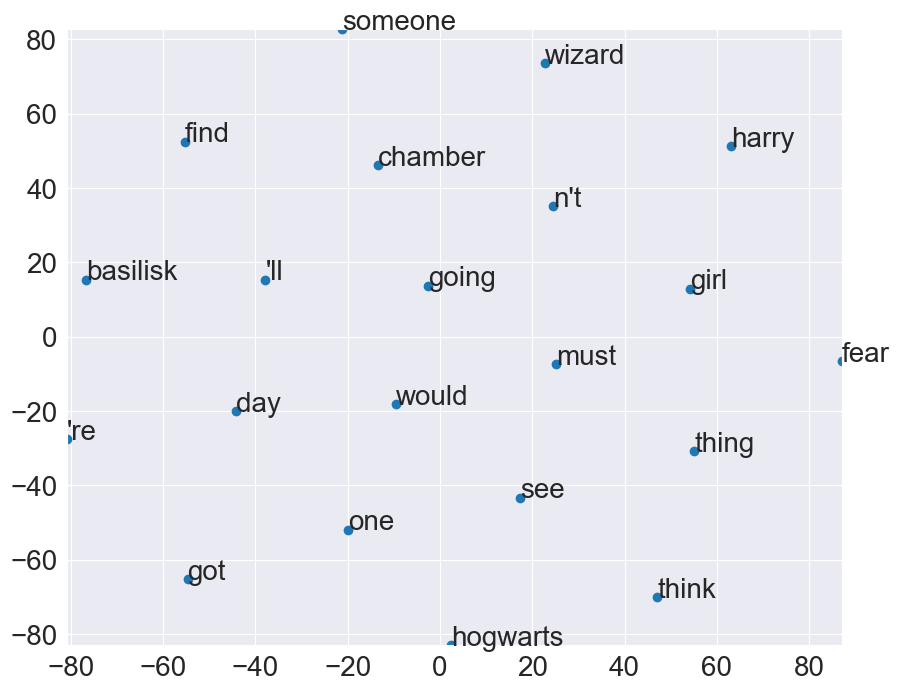

In [188]:
display_closestwords_tsnescatterplot(model,'chamber')

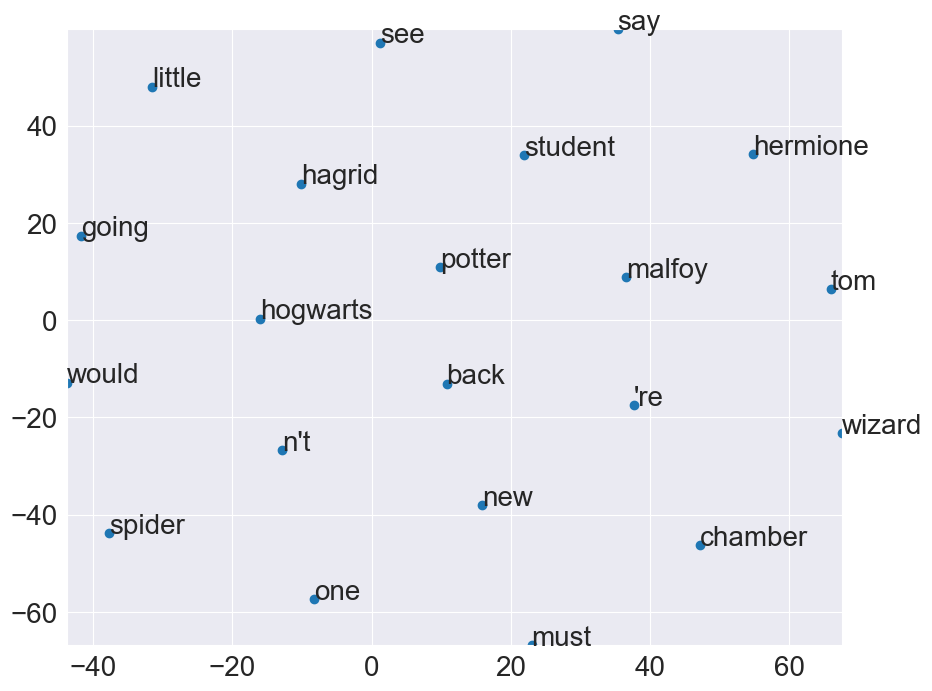

In [189]:
display_closestwords_tsnescatterplot(model,'hogwarts')

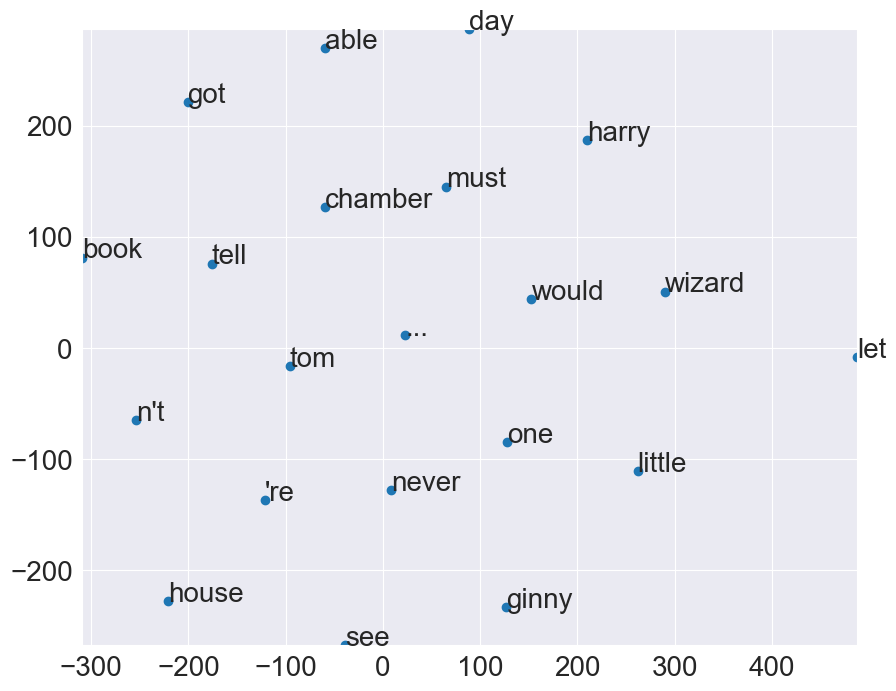

In [190]:
display_closestwords_tsnescatterplot(model,'ginny')

#Visulizing the embeddings

using the same loop

In [211]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:  # Use model.wv.index_to_key
        tokens.append(model.wv[word])
        labels.append(word)
    
    #initialize using PCA
    #take 2500 iterations over the data
    #n_components = 2 --> reduce dimensionality to 2
    #perplexity -- the higher the perplexity, the clearer the drawing, but computationally constly
    #read more here: https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tokens = np.array(tokens)  # Convert list to NumPy array
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

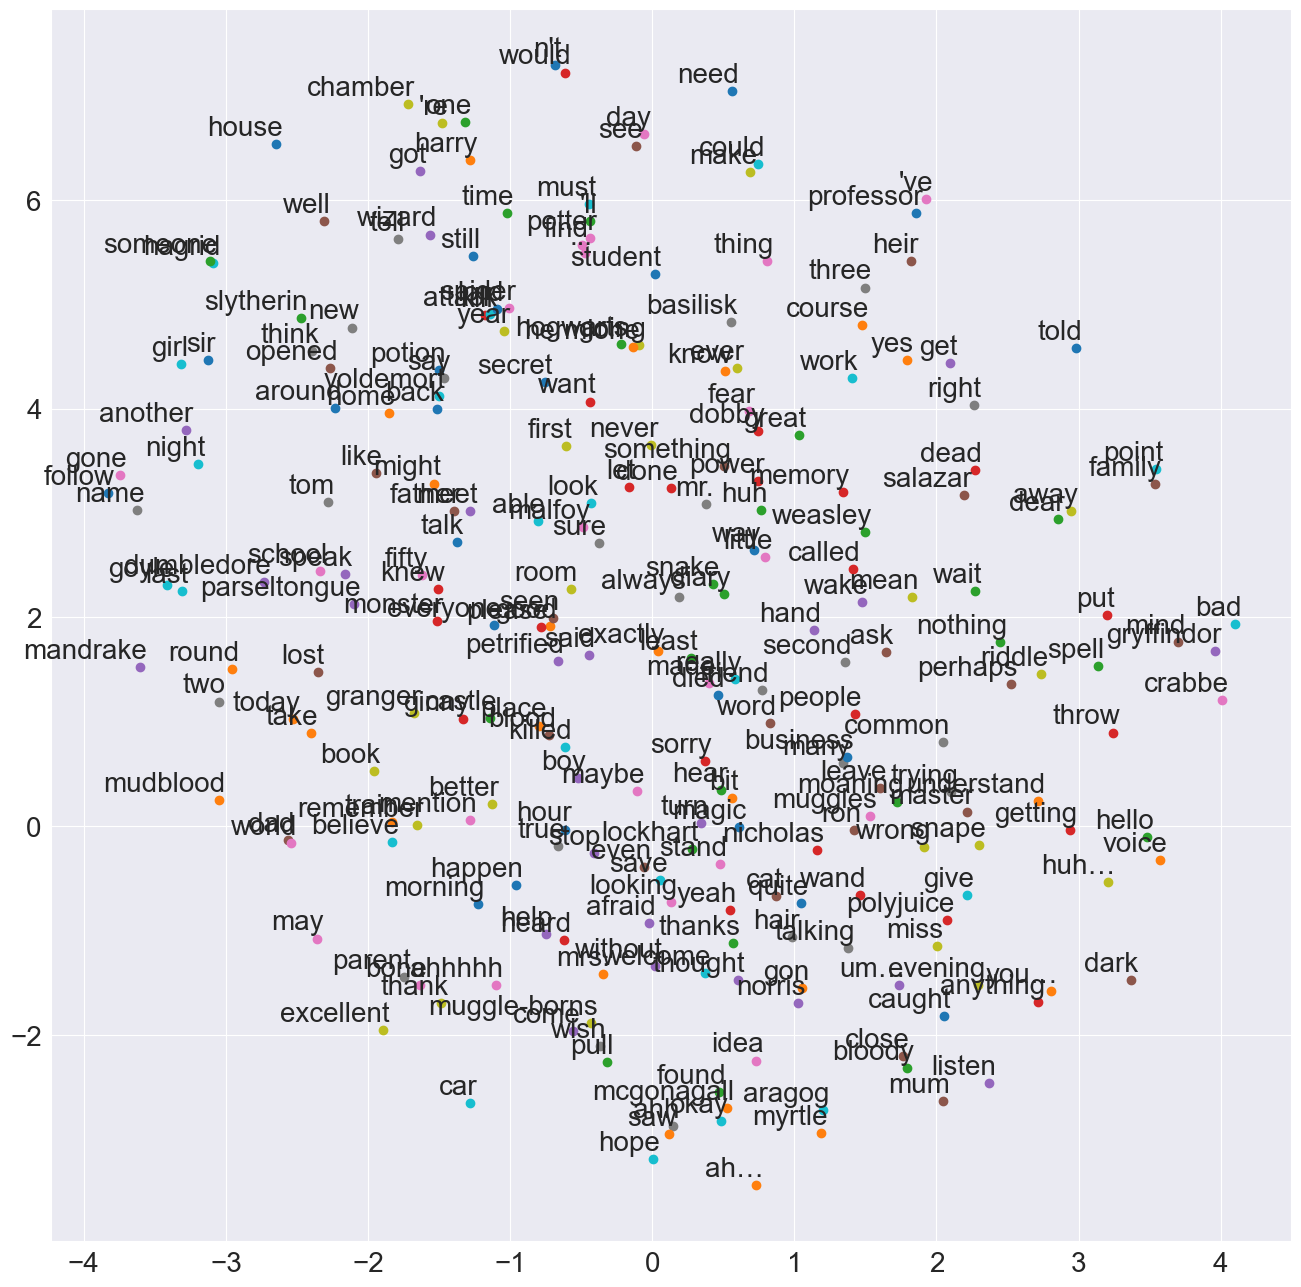

In [212]:
tsne_plot(model)

Increasing the Minimum Count of words in the corpus

initial model min_count was 5 now increased to 25

how ever we had to reduce the perplexity to 25

In [225]:
model = Word2Vec(df.clean_text.values, min_count=25,vector_size=300,workers=6, window=5)

In [236]:
def tsne_plot2(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:  # Use model.wv.index_to_key
        tokens.append(model.wv[word])
        labels.append(word)
    
    #initialize using PCA
    #take 2500 iterations over the data
    #n_components = 2 --> reduce dimensionality to 2
    #perplexity -- the higher the perplexity, the clearer the drawing, but computationally constly
    #read more here: https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html

    tsne_model = TSNE(perplexity=25, n_components=2, init='pca', n_iter=2500, random_state=23)
    tokens = np.array(tokens)  # Convert list to NumPy array
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

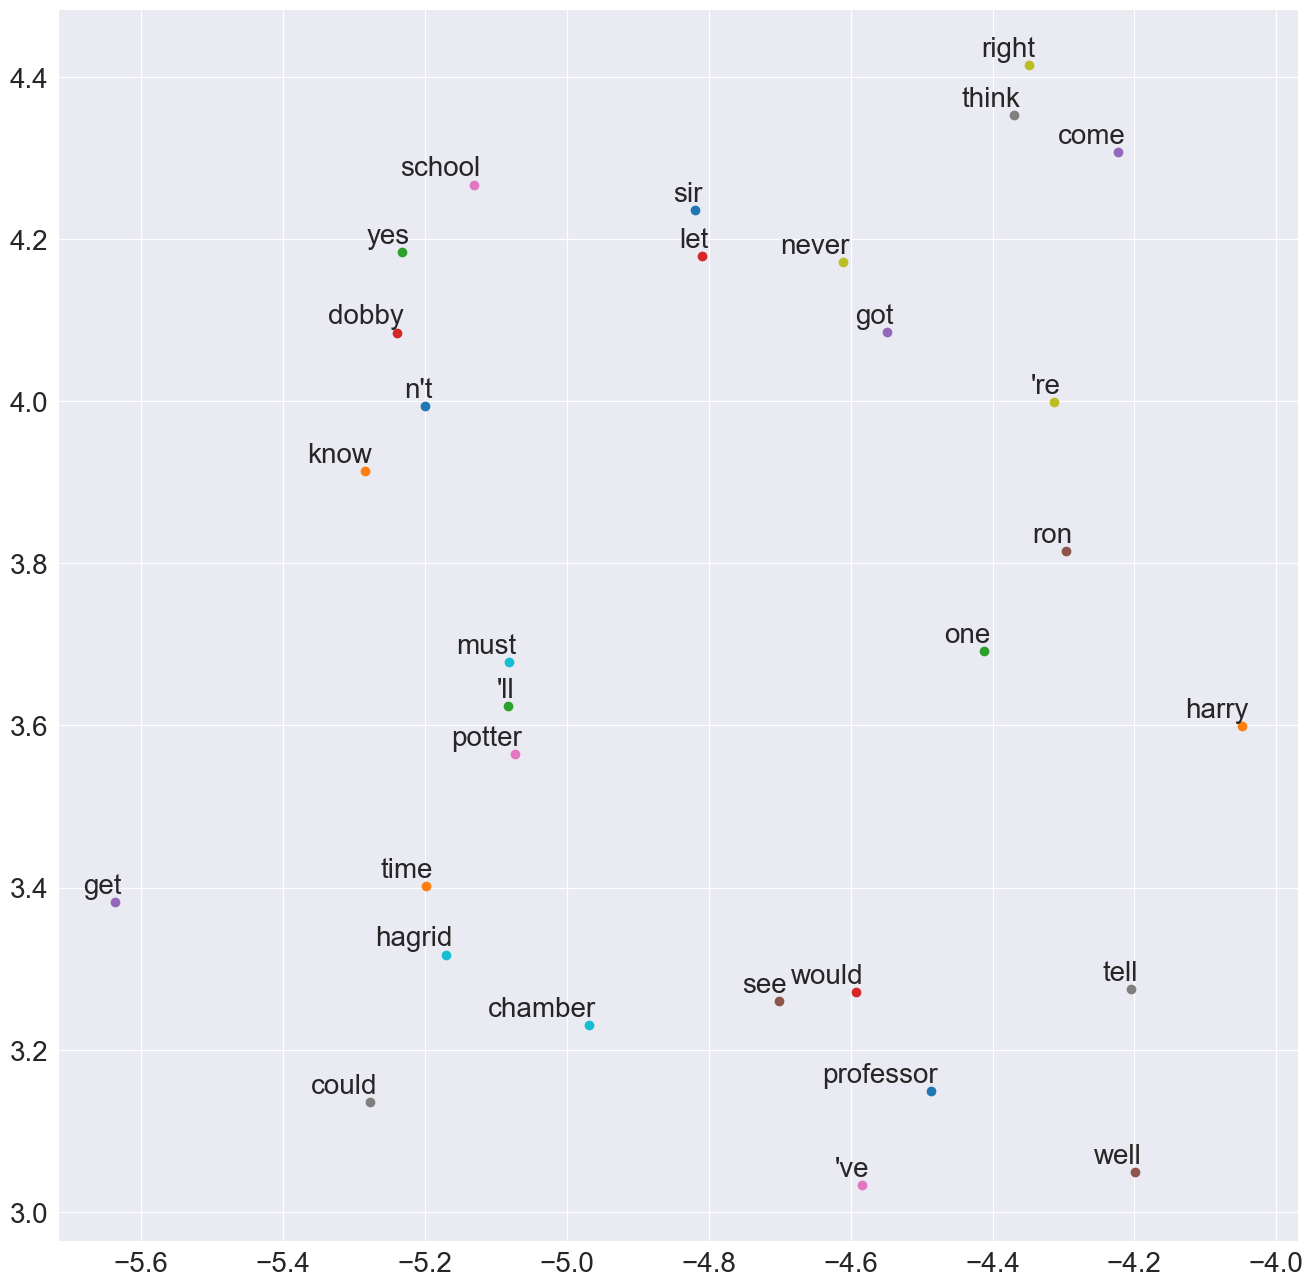

In [235]:
tsne_plot2(model)

Increasing it to 50

Reducing perplexity to 20

In [249]:
model = Word2Vec(df.clean_text.values, min_count=40,vector_size=300,workers=6, window=5)

In [250]:
def tsne_plot3(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:  # Use model.wv.index_to_key
        tokens.append(model.wv[word])
        labels.append(word)
    
    #initialize using PCA
    #take 2500 iterations over the data
    #n_components = 2 --> reduce dimensionality to 2
    #perplexity -- the higher the perplexity, the clearer the drawing, but computationally constly
    #read more here: https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html

    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=23)
    tokens = np.array(tokens)  # Convert list to NumPy array
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

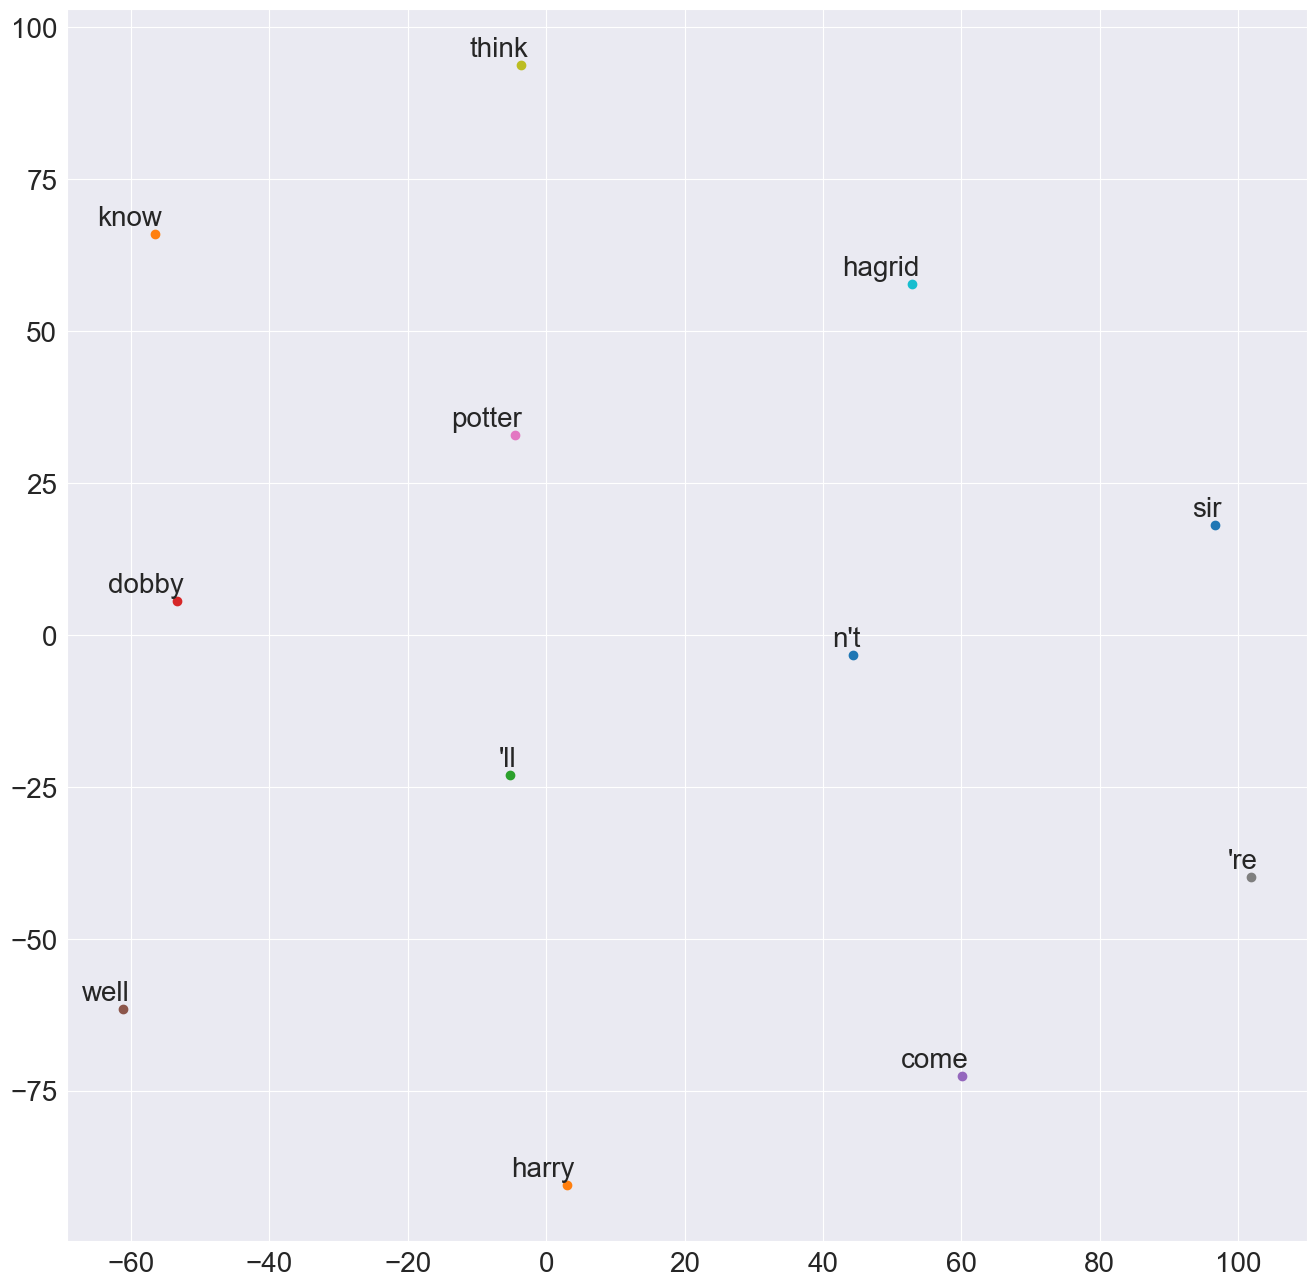

In [251]:
tsne_plot3(model)